In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

from utils import (get_train_mnist,
                   get_test_mnist, 
                   train,
                   test)

from plot import plot_weight_distribution
from args import args, kwargs

### Для начала обучим обычную модель, на датасете MNIST
### Сделаем все необходимые для этого импорты и подготовим код для обучения модели

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, bias=False)
        self.conv2 = nn.Conv2d(8, 8, 3, stride=5, bias=False)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        output = self.fc(x)
        return output

In [4]:
def train_and_eval(model, train_loader, test_loader):
    if args['cuda']:
        model.cuda()

    history = []
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    for epoch in range(1, args['epochs'] + 1):

        train(model, epoch, loss_fn, optimizer, train_loader)
        acc = test(model, loss_fn, optimizer, test_loader)
        history.append(acc)

    return acc

In [5]:
train_loader =  get_train_mnist()
test_loader= get_test_mnist()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:04<00:00, 2416929.32it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 258735.78it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2285435.93it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4501542.71it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
model = SimpleCNN()
hist = train_and_eval(model, train_loader, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325405
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.830444
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.293690
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.983411
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.854736
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.701936

Test set: Average loss: 0.0013, Accuracy: 7869/10000 (79%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.702703
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.616220
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.589727
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.610411
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.553593
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.502440

Test set: Average loss: 0.0010, Accuracy: 8409/10000 (84%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.586862
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.549536
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.512802
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.456867
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.521571
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

## Квантизация

$$
\frac{\partial \hat{v}}{\partial s} =
\begin{cases}
-\frac{v}{s} + \left\lfloor \frac{v}{s} \right\rceil & \text{if } -Q_N < \frac{v}{s} < Q_P, \\
-Q_N & \text{if } \frac{v}{s} \leq -Q_N, \\
Q_P & \text{if } \frac{v}{s} \geq Q_P.
\end{cases}
$$

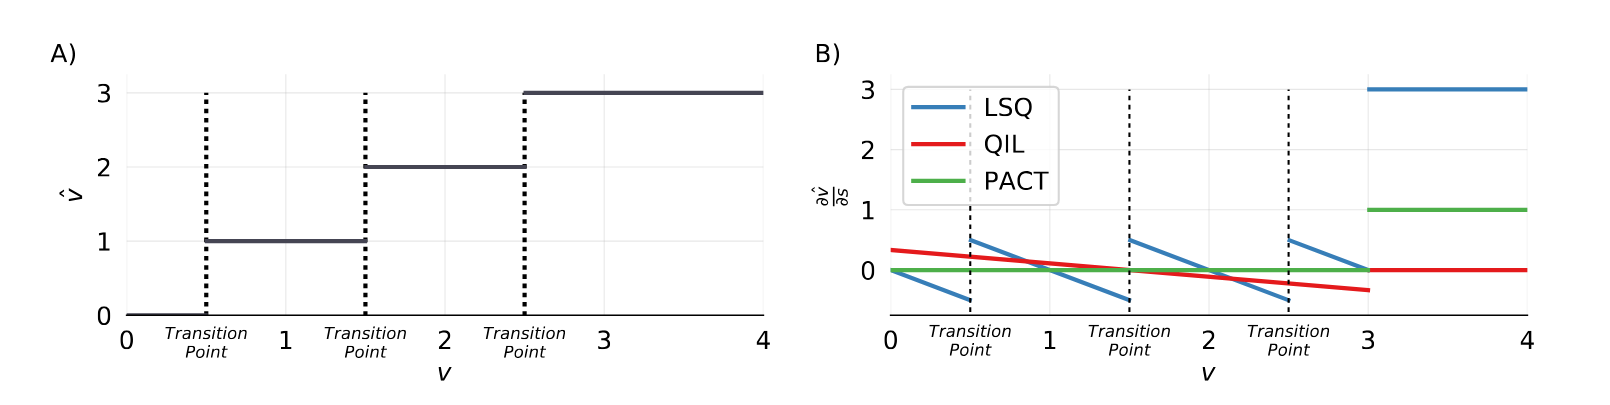

### Теперь мы хотим написать класс квантизатор, который будет квантизовать входящий тензор.
### Заметим что параметр S у нас будет обучамыем, но с другой стороны мы так же сможем его задать исходя из значений тензора.

In [ ]:
class Quantizer(nn.Module):
    def __init__(self, bit):

        super(Quantizer, self).__init__()
        self.bit = bit
        self.thd_neg = -(2 ** (bit - 1))
        self.thd_pos = 2 ** (bit - 1) - 1
        self.s = nn.Parameter(torch.ones(1))

    def init_from(self, x):
        s = (x.max() - x.min()) / (self.thd_pos - self.thd_neg )
        self.s = nn.Parameter(s)

    def skip_grad_scale(self,x, scale):
        y = x
        y_grad = x * scale
        return (y - y_grad).detach() + y_grad

    # LSQ pass
    def round_pass(self, x):
        y = x.round()
        y_grad = x
        return (y - y_grad).detach() + y_grad

    def forward(self, x):
        if self.bit >= 32:
            return x

        s_grad_scale = 1.0 / ((self.thd_pos * x.numel()) ** 0.5)  # emperial  !!! ???
        device = x.device

        s_scale = self.skip_grad_scale(self.s, s_grad_scale).to(device)

        x = x / (s_scale)
        x = torch.clamp(x, self.thd_neg, self.thd_pos)
        x = self.round_pass(x)

        x = x * (s_scale)
        return x

### Посмотрим на то как работает получившийся квантизатор

<Figure size 1000x700 with 0 Axes>

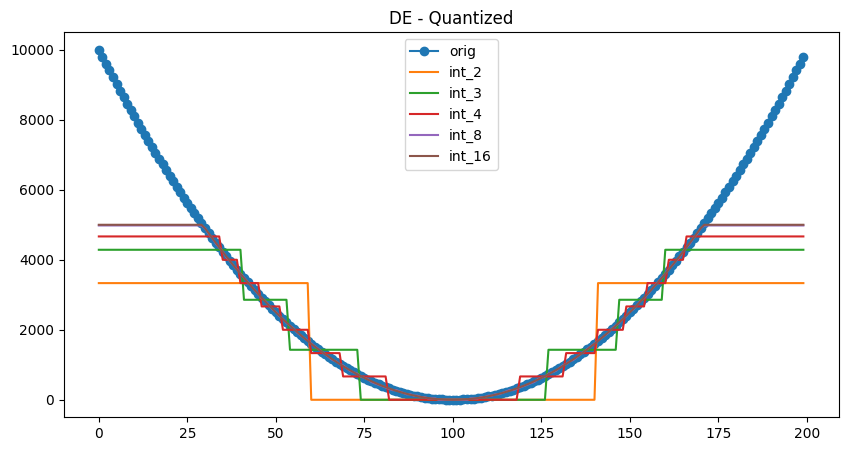

In [ ]:
vector =(np.arange(-100, 100, 1))**2

vector = torch.tensor(vector)

plt.figure(figsize=(10,7))

f = plt.figure(figsize = (10, 5))

plt.plot(range(len(vector)), vector,label='orig', marker='o')
for bit in [2,3,4, 8, 16]:
    quantizer = Quantizer(bit)
    quantizer.init_from(vector)
    dequantized = quantizer(vector)

    dequantized = dequantized.detach().numpy()

    plt.plot(range(len(vector)),dequantized,label=f'int_{bit}')

plt.title('DE - Quantized');
plt.legend();

### Небольшая функция для отрисовки гистограмм весов модели

3


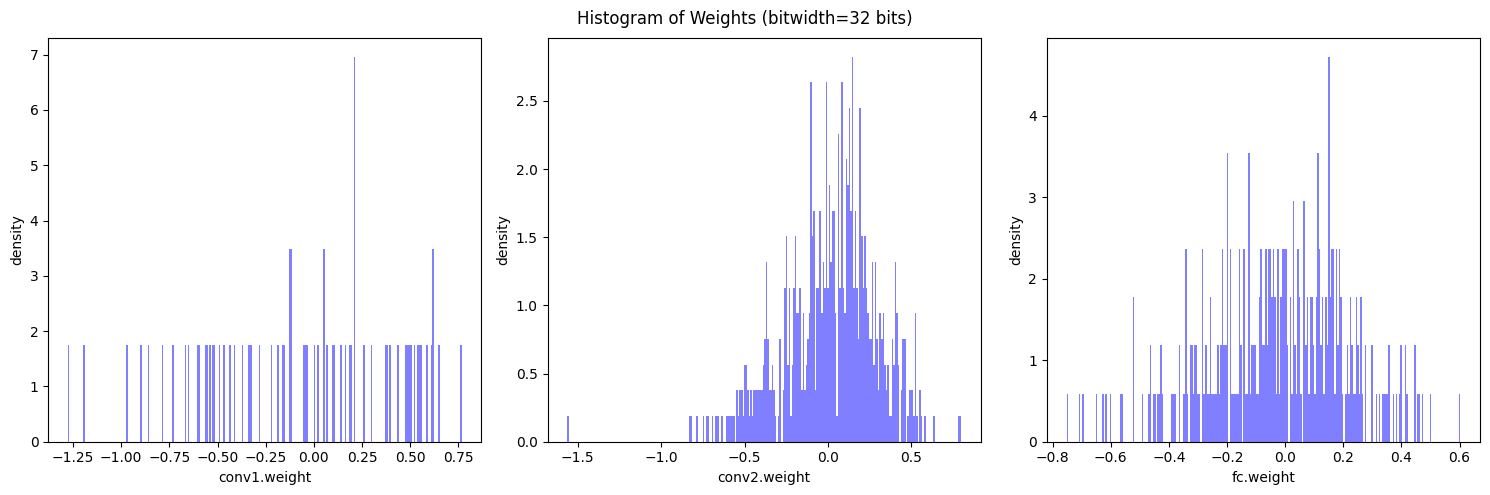

In [10]:
plot_weight_distribution(model,Quantizer, bitwidth=32)

3


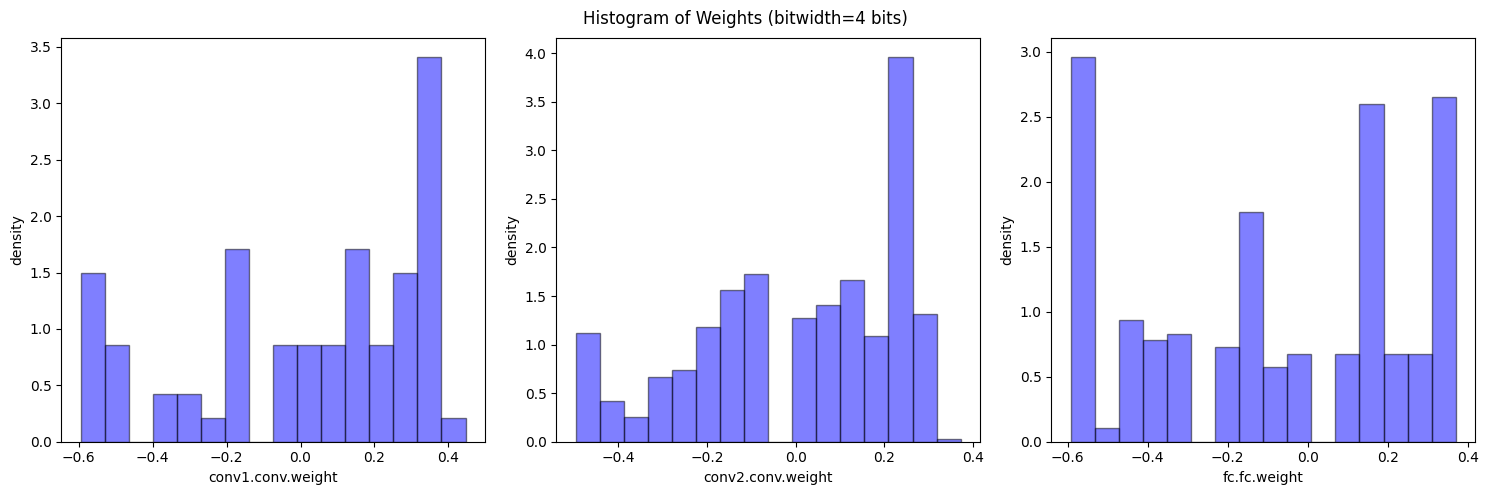

In [21]:
plot_weight_distribution(model,Quantizer,bitwidth=4)

### Теперь напишем функции сверточного и линейного слоев которые поддерживают квантизацию

In [ ]:
class QAConv2d(nn.Module):
    def __init__(self, bit, ch_in,ch_out, kernel=3, padding=0, stride=1):
        super(QAConv2d, self).__init__()
        self.bit = bit
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.kernel = kernel
        self.padding = padding
        self.stride = stride
        self.conv = nn.Conv2d(ch_in, ch_out, kernel, stride, padding, bias=False)
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weight = Quantizer(bit)
        self.quantizer_weight.init_from(self.conv.weight)

    def forward(self, input_x):
        quantized_weight = self.quantizer_weight(self.conv.weight)
        quantized_act= self.quantizer_act(input_x)
        out = nn.functional.conv2d(quantized_act, quantized_weight, None, self.stride, self.padding)
        return out

class QALinear(nn.Module):
    def __init__(self, bit, ch_in,ch_out):
        super(QALinear, self).__init__()
        self.bit = bit
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.fc = nn.Linear(ch_in, ch_out, bias=True)
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weigh = Quantizer(bit)
        self.quantizer_weigh.init_from(self.fc.weight)

        self.quantizer_bias = Quantizer(bit)

    def forward(self, input_x):
        quantized_bias = self.quantizer_bias(self.fc.bias)
        quantized_weight = self.quantizer_weigh(self.fc.weight)
        quantized_act = self.quantizer_act(input_x)
        out = nn.functional.linear(quantized_act, quantized_weight, bias=quantized_bias)
        return out

### Объявим нашу модель с учетом этих слоев

In [17]:
class QuanSimpleCNN(nn.Module):
    def __init__(self, bit):
        super(QuanSimpleCNN, self).__init__()
        self.conv1 = QAConv2d(bit,1, 8, 3, stride=1)
        self.conv2 = QAConv2d(bit,8, 8, 3, stride=5)
        self.fc = QALinear(bit, 32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        output = self.fc(x)
        return output

In [18]:
model = QuanSimpleCNN(32)
hist = train_and_eval(model, train_loader, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302042
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.648849
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.218979
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.895501
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.856087
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.680169

Test set: Average loss: 0.0013, Accuracy: 8004/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.667473
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.636330
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.604406
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.634884
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.666233
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.560147

Test set: Average loss: 0.0010, Accuracy: 8448/10000 (84%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.443692
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.477246
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.538393
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.560149
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.539172
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

3


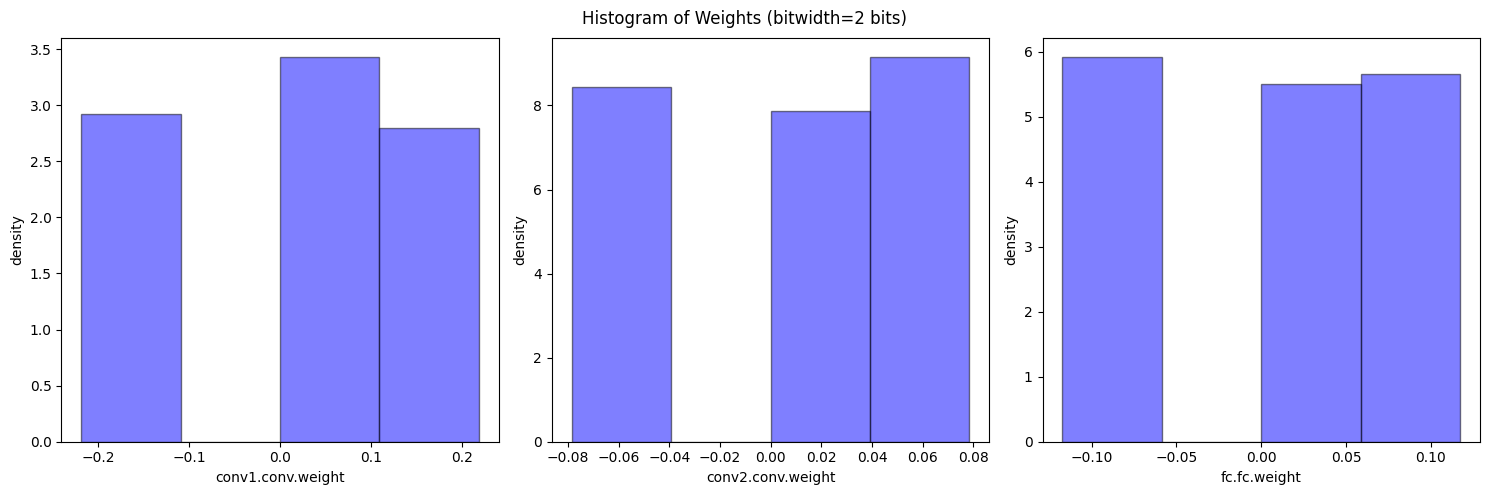

In [19]:
model = QuanSimpleCNN(2)
plot_weight_distribution(model,Quantizer, bitwidth=2)

In [20]:
hist = train_and_eval(model, train_loader, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302895
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.294511
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.143631
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.884079
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.609165
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.423288

Test set: Average loss: 0.0026, Accuracy: 5769/10000 (58%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.271829
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.480604
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.144579
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.185586
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.190936
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.174289

Test set: Average loss: 0.0022, Accuracy: 6313/10000 (63%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.122720
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.125480
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.181695
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.055597
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.078558
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

3


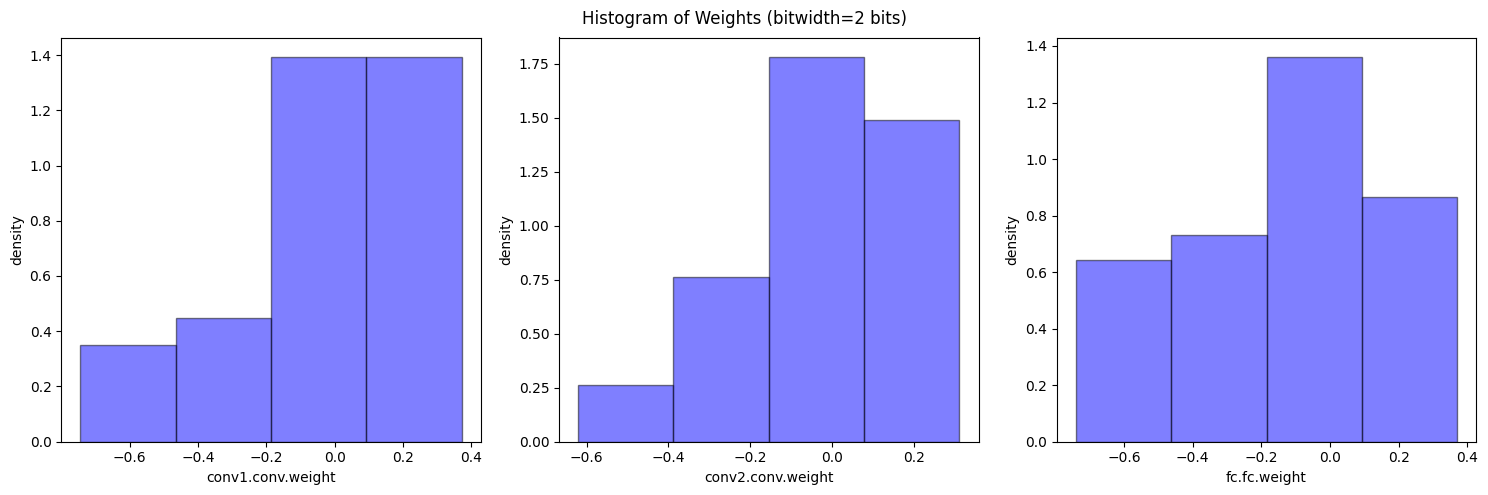

In [22]:
plot_weight_distribution(model,Quantizer, bitwidth=2)

In [23]:
model = QuanSimpleCNN(4)
hist = train_and_eval(model, train_loader, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319268
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.956903
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.614310
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.349588
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.091084
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.031898

Test set: Average loss: 0.0017, Accuracy: 7148/10000 (71%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.927451
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.854797
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.847516
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.750218
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.794297
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.682465

Test set: Average loss: 0.0013, Accuracy: 7910/10000 (79%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.737119
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.597582
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.662050
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.619413
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.807871
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

3


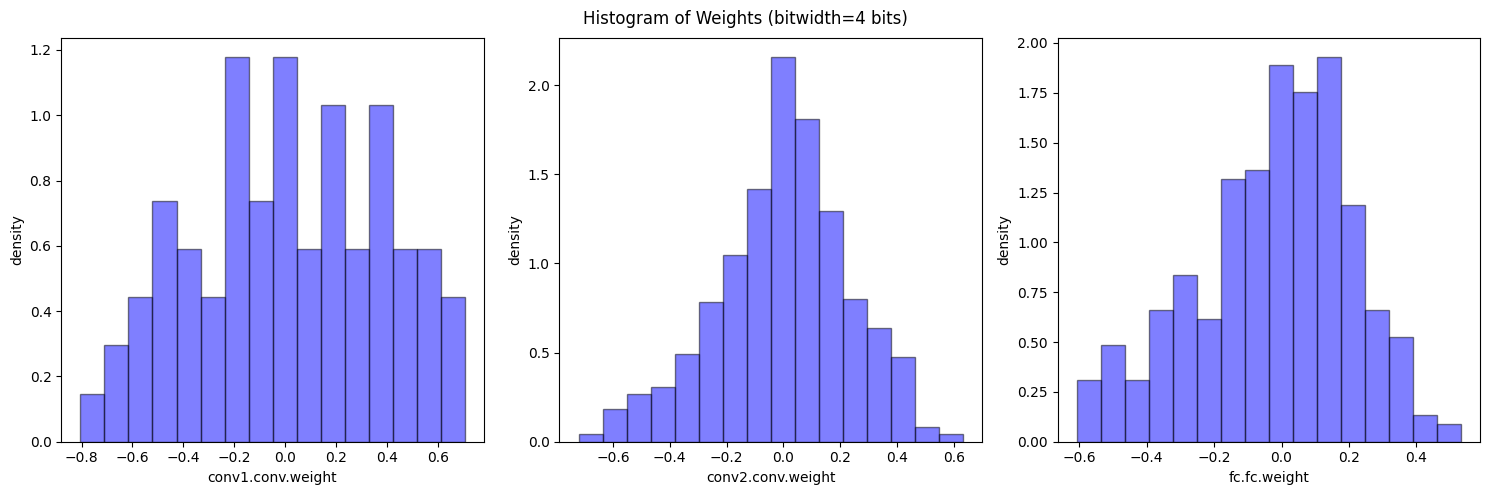

In [24]:
plot_weight_distribution(model,Quantizer,bitwidth=4)

In [27]:
model.conv1.quantizer_act.s, model.conv1.quantizer_weight.s 

(Parameter containing:
 tensor([0.7154], requires_grad=True),
 Parameter containing:
 tensor(0.0935, requires_grad=True))